# Join data from Transactions, reporting owner and submission

In this notebook we create a transactions_data table as follows
- Take valid transactions from NONDERIV_TRANS.tsv (~11k rows)
- Add a 'reporter' column using `RPTOWNER_RELATIONSHIP` from REPORTINGOWNER.tsv
- Add a 'ticker' column using `ISSUERTRADINGSYMBOL` from SUBMISSION.tsv

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


In [15]:
NONDERIV_PATH = r"../NONDERIV_TRANS.tsv"  # <-- update this

nonderiv_cols = ['ACCESSION_NUMBER', 'SECURITY_TITLE', 'TRANS_DATE', 'TRANS_SHARES',
                 'TRANS_PRICEPERSHARE', 'TRANS_CODE']

df_nonderiv = pd.read_csv(NONDERIV_PATH, sep='\t', usecols=nonderiv_cols, low_memory=False)
df_nonderiv.head()

,ACCESSION_NUMBER,SECURITY_TITLE,TRANS_DATE,TRANS_CODE,TRANS_SHARES,TRANS_PRICEPERSHARE
0,0001104659-25-030101,"Non-Voting Ordinary Shares, No Par Value",31-MAR-2025,J,1185242.00,3.01
1,0001104659-25-030099,"Non-Voting Ordinary Shares, No Par Value",31-MAR-2025,J,1185242.00,3.01
2,0000950170-25-048015,2024 Annual Restricted Stock Units,27-MAR-2025,A,13.24,NaN
3,0000950170-25-048008,2024 Annual Restricted Stock Units,27-MAR-2025,A,21.47,NaN
4,0000950170-25-048008,2024 Elective Restricted Stock Units,27-MAR-2025,A,5.88,NaN


## Basic information and missing values
We check the **shape**, **data types**, and **missing values** to understand data quality before applying any filters.

In [16]:
print('Shape:', df_nonderiv.shape)

Shape: (103029, 6)


In [17]:
missing = df_nonderiv.isnull().sum()
missing_pct = (missing / len(df_nonderiv) * 100).round(2)
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})
missing_df

,Missing Count,Missing %
ACCESSION_NUMBER,0,0.00
SECURITY_TITLE,0,0.00
TRANS_DATE,0,0.00
TRANS_CODE,1,0.00
TRANS_SHARES,0,0.00
TRANS_PRICEPERSHARE,7714,7.49


## Filter for COMMON stock and P/S transactions
We restrict the dataset to:
- Rows where `SECURITY_TITLE` contains **'COMMON'** (case-insensitive), and
- `TRANS_CODE` is either **'P' (Purchase)** or **'S' (Sale)**.

This focuses the analysis on standard insider buy/sell transactions in common stock.

In [18]:
df_filtered = df_nonderiv[
    df_nonderiv['SECURITY_TITLE'].str.contains('COMMON', case=False, na=False)
    & df_nonderiv['TRANS_CODE'].isin(['P', 'S'])
].copy()

print('Records after filtering:', len(df_filtered))
print('Percentage retained:', round(len(df_filtered) / len(df_nonderiv) * 100, 2), '%')

df_filtered['TRANS_CODE'].value_counts()

Records after filtering: 26190
Percentage retained: 25.42 %


TRANS_CODE
S    20798
P     5392
Name: count, dtype: int64

## Clean data

In [19]:
# Drop rows with transaction with no value
df_filtered = df_filtered[df_filtered['TRANS_SHARES'] > 0]
print('Records after filtering:', len(df_filtered))
df_filtered = df_filtered[df_filtered['TRANS_PRICEPERSHARE'] > 0]
print('Records after filtering:', len(df_filtered))

stats = df_filtered[['TRANS_SHARES', 'TRANS_PRICEPERSHARE']].describe()
stats

Records after filtering: 26159
Records after filtering: 26056


,TRANS_SHARES,TRANS_PRICEPERSHARE
count,2.605600e+04,26056.000000
mean,7.124525e+04,240.174041
std,1.563206e+06,7279.762767
min,4.000000e-02,0.010000
25%,5.187500e+02,13.530000
50%,2.316000e+03,54.275000
75%,1.000000e+04,191.430000
max,1.946288e+08,878401.000000


In [20]:
df_filtered['TRANS_DATE'] = pd.to_datetime(df_filtered['TRANS_DATE'], errors='coerce')
df_filtered['year'] = df_filtered['TRANS_DATE'].dt.year
#print(df_filtered.head())

# Keep 2025 transactions only
df_filtered = df_filtered[df_filtered['year'] == 2025]
print('Records after filtering for 2025 only:', len(df_filtered))

# Transactions per month in 2025
df_filtered['month'] = df_filtered['TRANS_DATE'].dt.month
rows_per_month = df_filtered.groupby('month').size()
print("Rows per month in 2025:")
print(rows_per_month)


Records after filtering for 2025 only: 24959
Rows per month in 2025:
month
1     6715
2     9053
3     9189
10       2
dtype: int64


There are a couple of invalid transactions with date after end of Q1 (after March). Let's drop those transactions

In [21]:
df_filtered = df_filtered[df_filtered['month'].isin([1, 2, 3, 4])]
print('Records after filtering for January to April 2025:', len(df_filtered))

# Recheck transactions per month in 2025
df_filtered['month'] = df_filtered['TRANS_DATE'].dt.month
rows_per_month = df_filtered.groupby('month').size()
print("Rows per month in 2025:")
print(rows_per_month)

Records after filtering for January to April 2025: 24957
Rows per month in 2025:
month
1    6715
2    9053
3    9189
dtype: int64


## Creating dollar_value

In [22]:
numeric_cols = ['TRANS_SHARES', 'TRANS_PRICEPERSHARE']
for col in numeric_cols:
    df_filtered[col] = pd.to_numeric(df_filtered[col], errors='coerce')

df_filtered['dollar_value'] = df_filtered['TRANS_SHARES'] * df_filtered['TRANS_PRICEPERSHARE']
stats = df_filtered[['TRANS_SHARES', 'TRANS_PRICEPERSHARE', 'dollar_value']].describe()
stats

,TRANS_SHARES,TRANS_PRICEPERSHARE,dollar_value
count,2.495700e+04,24957.000000,2.495700e+04
mean,7.098277e+04,248.097259,1.863083e+06
std,1.589096e+06,7438.171736,3.025458e+07
min,4.000000e-02,0.020000,1.184000e+00
25%,5.680000e+02,14.380000,3.045200e+04
50%,2.400000e+03,59.430000,1.483045e+05
75%,1.010900e+04,200.050000,5.689234e+05
max,1.946288e+08,878401.000000,2.740968e+09


## Merging transactions that belong to the same submission

Drop rows with same ACCESSION_NUMBER have conflicting TRANS_CODE.

In [23]:
# Drop rows with conflicting TRANS_CODE
grouped_codes = df_filtered.groupby('ACCESSION_NUMBER')['TRANS_CODE'].nunique()
conflicting_accessions = grouped_codes[grouped_codes > 1]

df_filtered = df_filtered[~df_filtered['ACCESSION_NUMBER'].isin(conflicting_accessions.index)]
print('Records after dropping conflicting TRANS_CODE:', len(df_filtered))

Records after dropping conflicting TRANS_CODE: 24805


Let's combine the transactions that are part of the same submision (same ACCESSION_NUMBER)

In [24]:
# Sort by ACCESSION_NUMBER and TRANS_DATE
df_filtered = df_filtered.sort_values(['ACCESSION_NUMBER', 'TRANS_DATE'])

# Group by ACCESSION_NUMBER and aggregate
df_combined = df_filtered.groupby('ACCESSION_NUMBER').agg({
    'SECURITY_TITLE': 'last',
    'TRANS_CODE': 'last',
    'TRANS_SHARES': 'sum',
    'TRANS_PRICEPERSHARE': lambda x: (df_filtered.loc[x.index, 'dollar_value'].sum() / 
                                       df_filtered.loc[x.index, 'TRANS_SHARES'].sum()) 
                                      if df_filtered.loc[x.index, 'TRANS_SHARES'].sum() > 0 else 0,
    'dollar_value': 'sum',
    'year': 'last',
    'TRANS_DATE': 'last'
}).reset_index()

print('Shape after combining:', df_combined.shape)
df_combined.head()

Shape after combining: (11747, 8)


,ACCESSION_NUMBER,SECURITY_TITLE,TRANS_CODE,TRANS_SHARES,TRANS_PRICEPERSHARE,dollar_value,year,TRANS_DATE
0,0000002488-25-000014,Common Stock,P,4645.0,107.560000,499616.20,2025,2025-02-07
1,0000002488-25-000016,Common Stock,S,17500.0,113.574009,1987545.16,2025,2025-02-14
2,0000002488-25-000034,Common Stock,S,17500.0,100.267104,1754674.32,2025,2025-03-14
3,0000003570-25-000038,Common Stock,S,23478.0,216.430000,5081343.54,2025,2025-02-26
4,0000003570-25-000040,Common Stock,S,9000.0,219.510000,1975590.00,2025,2025-02-27


In [25]:
# Drop columns that will not be used for modeling 

df_combined = df_combined.drop(columns=['SECURITY_TITLE', 'year', 'TRANS_SHARES', 'TRANS_PRICEPERSHARE'])
df_combined = df_combined.rename(columns={'TRANS_DATE': 'date', 'TRANS_CODE': 'side'})

# Convert TRANS_CODE to buy/sell
df_combined['side'] = df_combined['side'].map({'P': 'buy', 'S': 'sell'})

print('Columns after dropping:', df_combined.columns.tolist())
df_combined.head()

Columns after dropping: ['ACCESSION_NUMBER', 'side', 'dollar_value', 'date']


,ACCESSION_NUMBER,side,dollar_value,date
0,0000002488-25-000014,buy,499616.20,2025-02-07
1,0000002488-25-000016,sell,1987545.16,2025-02-14
2,0000002488-25-000034,sell,1754674.32,2025-03-14
3,0000003570-25-000038,sell,5081343.54,2025-02-26
4,0000003570-25-000040,sell,1975590.00,2025-02-27


## Visualizations
Below we plot:
- Buy vs Sell transaction counts
- Distribution of dollar values (log scale to handle skew)
These plots help visually confirm patterns seen in the summary statistics.

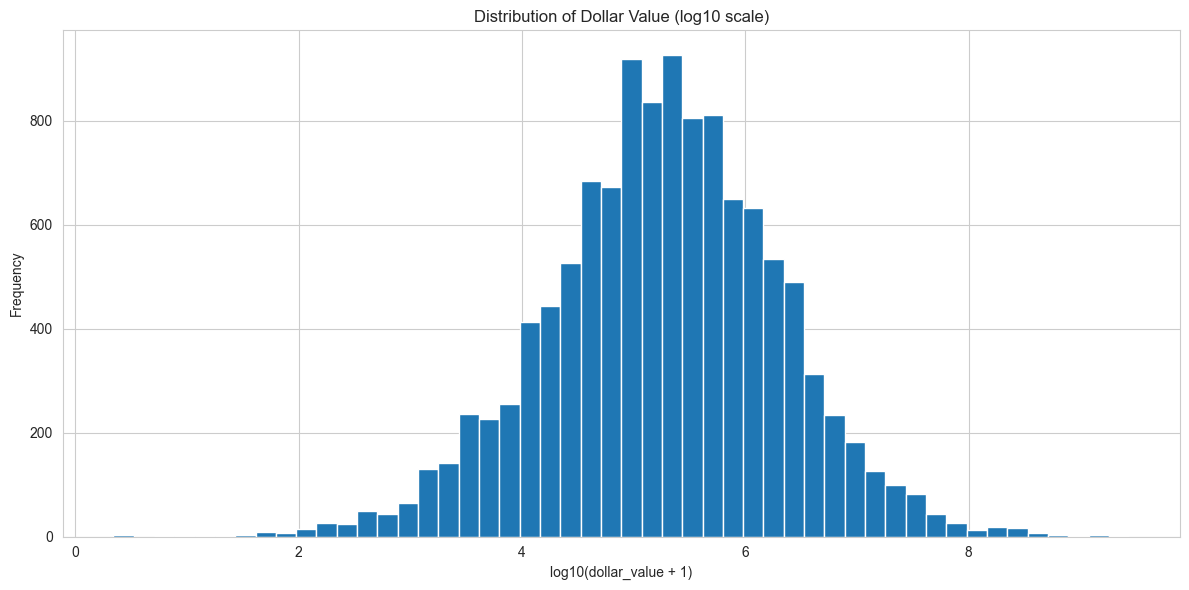

In [27]:

plt.figure()
dv_log = np.log10(df_combined['dollar_value'].dropna() + 1)    # log base 20
#dv_log = np.log1p(df_combined['dollar_value'].dropna() + 1)     # natural log
dv_log.plot(kind='hist', bins=50)
plt.title('Distribution of Dollar Value (log10 scale)')
plt.xlabel('log10(dollar_value + 1)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## Log Transformation for dollar_value

In [28]:
df_combined["log_dollar_value"] = np.log1p(df_combined["dollar_value"].clip(lower=0))
df_combined.head()

,ACCESSION_NUMBER,side,dollar_value,date,log_dollar_value
0,0000002488-25-000014,buy,499616.20,2025-02-07,13.121597
1,0000002488-25-000016,sell,1987545.16,2025-02-14,14.502411
2,0000002488-25-000034,sell,1754674.32,2025-03-14,14.377794
3,0000003570-25-000038,sell,5081343.54,2025-02-26,15.441086
4,0000003570-25-000040,sell,1975590.00,2025-02-27,14.496378


## Bringing Role from REPORTINGOWNER.tsv

In [29]:
REPORTINGOWNER_PATH = r"../REPORTINGOWNER.tsv"  # <-- update this

df_owner = pd.read_csv(REPORTINGOWNER_PATH, sep='\t', low_memory=False)
df_owner.head()

,ACCESSION_NUMBER,RPTOWNERCIK,RPTOWNERNAME,RPTOWNER_RELATIONSHIP,RPTOWNER_TITLE,RPTOWNER_TXT,RPTOWNER_STREET1,RPTOWNER_STREET2,RPTOWNER_CITY,RPTOWNER_STATE,RPTOWNER_ZIPCODE,RPTOWNER_STATE_DESC,FILE_NUMBER
0,0001104659-25-030101,1449433,"Apollo Management Holdings GP, LLC",TenPercentOwner,NaN,NaN,"9 WEST 57TH STREET, 43RD FLOOR",NaN,NEW YORK,NY,10019,NaN,001-40566
1,0001104659-25-030101,1413410,"Apollo Management GP, LLC",TenPercentOwner,NaN,NaN,"9 WEST 57TH STREET, 43RD FLOOR",NaN,NEW YORK,NY,10019,NaN,001-40566
2,0001104659-25-030101,1449434,"Apollo Management Holdings, L.P.",TenPercentOwner,NaN,NaN,"9 WEST 57TH STREET, 43RD FLOOR",NaN,NEW YORK,NY,10019,NaN,001-40566
3,0001104659-25-030099,1934842,"College Parent Holdings GP, LLC",TenPercentOwner,NaN,NaN,"9 WEST 57TH STREET, 43RD FLOOR",NaN,NEW YORK,NY,10019,NaN,001-40566
4,0001104659-25-030099,1784683,"Apollo Management IX, L.P.",TenPercentOwner,NaN,NaN,"9 WEST 57TH STREET, 43RD FLOOR",NaN,NEW YORK,NY,10019,NaN,001-40566


In [30]:
print('Number of unique ACCESSION_NUMBER in df_owner:', df_owner['ACCESSION_NUMBER'].nunique())
print(f'Total rows {len(df_owner)}')

Number of unique ACCESSION_NUMBER in df_owner: 63284
Total rows 66287


Let's merge rows with the same id and also simplify the RPTOWNER_RELATIONSHIP to have only four possible values

In [31]:
def get_simplified_role(rel):
    if not isinstance(rel, str):
        return 'OTHER'
    r = rel.upper()
    if 'OFFICER' in r:
        return 'OFFICER'
    elif 'DIRECTOR' in r:
        return 'DIRECTOR'
    elif 'TENPERCENTOWNER' in r or '10% OWNER' in r:
        return 'TENPERCENTOWNER'
    else:
        return 'OTHER'

# Apply simplification
df_owner['simplified'] = df_owner['RPTOWNER_RELATIONSHIP'].apply(get_simplified_role)

# Assign sort key for precedence: OFFICER > DIRECTOR > TENPERCENTOWNER > OTHER
sort_order = {'OFFICER': 1, 'DIRECTOR': 2, 'TENPERCENTOWNER': 3, 'OTHER': 4}
df_owner['sort_key'] = df_owner['simplified'].map(sort_order)

# Sort by ACCESSION_NUMBER and sort_key, then drop duplicates keeping the first (highest precedence)
df_owner = df_owner.sort_values(['ACCESSION_NUMBER', 'sort_key']).drop_duplicates('ACCESSION_NUMBER', keep='first')

# Update the column and drop temp columns
df_owner['RPTOWNER_RELATIONSHIP'] = df_owner['simplified']
df_owner = df_owner.drop(columns=['simplified', 'sort_key'])

print('Shape after merging and simplifying:', df_owner.shape)
print('Updated unique RPTOWNER_RELATIONSHIP values:')
print(df_owner['RPTOWNER_RELATIONSHIP'].value_counts())
df_owner.head()

Shape after merging and simplifying: (63284, 13)
Updated unique RPTOWNER_RELATIONSHIP values:
RPTOWNER_RELATIONSHIP
OFFICER            43658
DIRECTOR           17242
TENPERCENTOWNER     1399
OTHER                985
Name: count, dtype: int64
 (63284, 13)
Updated unique RPTOWNER_RELATIONSHIP values:
RPTOWNER_RELATIONSHIP
OFFICER            43658
DIRECTOR           17242
TENPERCENTOWNER     1399
OTHER                985
Name: count, dtype: int64


,ACCESSION_NUMBER,RPTOWNERCIK,RPTOWNERNAME,RPTOWNER_RELATIONSHIP,RPTOWNER_TITLE,RPTOWNER_TXT,RPTOWNER_STREET1,RPTOWNER_STREET2,RPTOWNER_CITY,RPTOWNER_STATE,RPTOWNER_ZIPCODE,RPTOWNER_STATE_DESC,FILE_NUMBER
47126,0000002178-25-000033,1942707,Bosard Trey T,OFFICER,"President, Phoenix Oil, Inc.",NaN,2727 ALLEN PARKWAY,9TH FLOOR,HOUSTON,TX,77019,NaN,001-07908
47105,0000002178-25-000035,1637261,Brasseux Murray E,DIRECTOR,NaN,NaN,2727 ALLEN PARKWAY,9TH FLOOR,HOUSTON,TX,77019,NaN,001-07908
47085,0000002178-25-000037,1793661,Dominic Dennis E.,DIRECTOR,NaN,NaN,2727 ALLEN PARKWAY,9TH FLOOR,HOUSTON,TX,77019,NaN,001-07908
47073,0000002178-25-000039,1637080,Earley Michelle A,DIRECTOR,NaN,NaN,2727 ALLEN PARKWAY,9TH FLOOR,HOUSTON,TX,77019,NaN,001-07908
47065,0000002178-25-000041,1675254,Jenner Richard C,DIRECTOR,NaN,NaN,2727 ALLEN PARKWAY,9TH FLOOR,HOUSTON,TX,77019,NaN,001-07908


In [32]:
df_join = df_combined.merge(df_owner[['ACCESSION_NUMBER', 'RPTOWNER_RELATIONSHIP']], on='ACCESSION_NUMBER', how='inner')
df_join = df_join.rename(columns={'RPTOWNER_RELATIONSHIP': 'role'})
print('Shape of df_join:', df_join.shape)
df_join.head()

Shape of df_join: (11747, 6)


,ACCESSION_NUMBER,side,dollar_value,date,log_dollar_value,role
0,0000002488-25-000014,buy,499616.20,2025-02-07,13.121597,OFFICER
1,0000002488-25-000016,sell,1987545.16,2025-02-14,14.502411,OFFICER
2,0000002488-25-000034,sell,1754674.32,2025-03-14,14.377794,OFFICER
3,0000003570-25-000038,sell,5081343.54,2025-02-26,15.441086,OFFICER
4,0000003570-25-000040,sell,1975590.00,2025-02-27,14.496378,DIRECTOR


## Bringing ticker from SUBMISSION.tsv

In [33]:
SUBMISSION_PATH = r"../SUBMISSION.tsv"  # <-- update this

df_submission = pd.read_csv(SUBMISSION_PATH, sep='\t', low_memory=False)
df_submission = df_submission[['ACCESSION_NUMBER', 'ISSUERTRADINGSYMBOL', 'AFF10B5ONE']]
print(len(df_submission))
df_submission.head()

63284


,ACCESSION_NUMBER,ISSUERTRADINGSYMBOL,AFF10B5ONE
0,0001104659-25-030099,TBLA,0
1,0001127602-25-010616,LH,0
2,0001451809-25-000066,SITM,0
3,0001805077-25-000039,EOSE,NaN
4,0000905148-25-001026,WLFC,false


Let's clean the data

In [34]:
# Handle AFF10B5ONE values
if 'AFF10B5ONE' in df_submission.columns:
    # Replace string/boolean values
    df_submission['AFF10B5ONE'] = df_submission['AFF10B5ONE'].replace({'false': 0, 'true': 1, False: 0, True: 1})
    
    # Drop rows where AFF10B5ONE is NaN
    df_submission = df_submission.dropna(subset=['AFF10B5ONE'])
    
    # Ensure it's integer type
    df_submission['AFF10B5ONE'] = df_submission['AFF10B5ONE'].astype(int)
    
    print('Updated AFF10B5ONE value counts:')
    print(df_submission['AFF10B5ONE'].value_counts())
    print('Shape after processing:', df_submission.shape)
else:
    print('AFF10B5ONE column not found in df_submission.')

Updated AFF10B5ONE value counts:
AFF10B5ONE
0    54922
1     4942
Name: count, dtype: int64
Shape after processing: (59864, 3)


In [35]:
# Remove rows with missing ticker
df_submission = df_submission.dropna(subset=['ISSUERTRADINGSYMBOL'])
print('Shape after dropping rows with missing ISSUERTRADINGSYMBOL:', df_submission.shape)

"""
missing_tickers = df_submission["ISSUERTRADINGSYMBOL"].isnull().sum()
total_rows = len(df_submission)
missing_pct = (missing_tickers / total_rows * 100).round(2) if total_rows > 0 else 0

print(f"Total rows: {total_rows}")
print(f"Missing tickers: {missing_tickers} ({missing_pct}%)")

if missing_tickers > 0:
    print("Sample rows with missing tickers:")
    display(df_submission[df_submission["ticker"].isnull()].head())

"""

Shape after dropping rows with missing ISSUERTRADINGSYMBOL: (59751, 3)


'\nmissing_tickers = df_submission["ISSUERTRADINGSYMBOL"].isnull().sum()\ntotal_rows = len(df_submission)\nmissing_pct = (missing_tickers / total_rows * 100).round(2) if total_rows > 0 else 0\n\nprint(f"Total rows: {total_rows}")\nprint(f"Missing tickers: {missing_tickers} ({missing_pct}%)")\n\nif missing_tickers > 0:\n    print("Sample rows with missing tickers:")\n    display(df_submission[df_submission["ticker"].isnull()].head())\n\n'

In [36]:
df_join = df_join.merge(df_submission[['ACCESSION_NUMBER', 'ISSUERTRADINGSYMBOL', 'AFF10B5ONE']], on='ACCESSION_NUMBER', how='inner')
df_join = df_join.rename(columns={'ISSUERTRADINGSYMBOL': 'ticker', 'AFF10B5ONE': 'is_10b5_1'})
print('Shape of df_join:', df_join.shape)

Shape of df_join: (11733, 8)


In [37]:
df_join.head()

,ACCESSION_NUMBER,side,dollar_value,date,log_dollar_value,role,ticker,is_10b5_1
0,0000002488-25-000014,buy,499616.20,2025-02-07,13.121597,OFFICER,AMD,0
1,0000002488-25-000016,sell,1987545.16,2025-02-14,14.502411,OFFICER,AMD,1
2,0000002488-25-000034,sell,1754674.32,2025-03-14,14.377794,OFFICER,AMD,1
3,0000003570-25-000038,sell,5081343.54,2025-02-26,15.441086,OFFICER,LNG,0
4,0000003570-25-000040,sell,1975590.00,2025-02-27,14.496378,DIRECTOR,LNG,0


In [38]:
value_counts = df_join['is_10b5_1'].value_counts()
percentages = (value_counts / len(df_submission)) * 100
print('Percentages:')
print(percentages.round(2))

Percentages:
is_10b5_1
0    12.19
1     7.45
Name: count, dtype: float64


In [39]:
# Number of unique tickers
value_counts = df_join['ticker'].value_counts()
print(value_counts)

ticker
TEAM    133
NONE    112
META     72
TPL      62
RCG      59
       ... 
SBRA      1
BTO       1
HEQ       1
JHS       1
MATW      1
Name: count, Length: 2373, dtype: int64


## Last check for missing values before storing data in Parquet

In [40]:
missing = df_join.isnull().sum()
missing_pct = (missing / len(df_join) * 100).round(2)
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})

print("Missing values in df_join:")
print(missing_df)

Missing values in df_join:
                  Missing Count  Missing %
ACCESSION_NUMBER              0        0.0
side                          0        0.0
dollar_value                  0        0.0
date                          0        0.0
log_dollar_value              0        0.0
role                          0        0.0
ticker                        0        0.0
is_10b5_1                     0        0.0


In [42]:
df_join.to_parquet("data/raw/events_2025Q1.parquet") 